In [2]:
import re
import os
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
    print("Device:", tpu.master())
    strategy = tf.distribute.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print("Number of replicas:", strategy.num_replicas_in_sync)


2024-06-18 10:21:39.968267: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-18 10:21:39.969615: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-18 10:21:40.106722: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-18 10:21:40.652900: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-18 10:21:41.652659: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warnin

Number of replicas: 1


In [3]:
AUTOTUNE = tf.data.AUTOTUNE
BATCH_SIZE = 25 * strategy.num_replicas_in_sync
IMAGE_SIZE = [180, 180]
CLASS_NAMES = ["NORMAL", "PNEUMONIA"]


In [4]:
train_images = tf.data.TFRecordDataset(
    "gs://download.tensorflow.org/data/ChestXRay2017/train/images.tfrec"
)
train_paths = tf.data.TFRecordDataset(
    "gs://download.tensorflow.org/data/ChestXRay2017/train/paths.tfrec"
)

ds = tf.data.Dataset.zip((train_images, train_paths))


In [5]:
COUNT_NORMAL = len(
    [
        filename
        for filename in train_paths
        if "NORMAL" in filename.numpy().decode("utf-8")
    ]
)
print("Normal images count in training set: " + str(COUNT_NORMAL))

COUNT_PNEUMONIA = len(
    [
        filename
        for filename in train_paths
        if "PNEUMONIA" in filename.numpy().decode("utf-8")
    ]
)
print("Pneumonia images count in training set: " + str(COUNT_PNEUMONIA))


2024-06-18 10:21:48.370210: W external/local_tsl/tsl/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "NOT_FOUND: Could not locate the credentials file.". Retrieving token from GCE failed with "FAILED_PRECONDITION: Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Could not resolve host: metadata.google.internal".
2024-06-18 10:21:49.173033: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Normal images count in training set: 1349
Pneumonia images count in training set: 3883


2024-06-18 10:21:49.896483: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [6]:
def get_label(file_path):
    # convert the path to a list of path components
    parts = tf.strings.split(file_path, "/")
    # The second to last is the class-directory
    if parts[-2] == "PNEUMONIA":
        return 1
    else:
        return 0


def decode_img(img):
    # convert the compressed string to a 3D uint8 tensor
    img = tf.image.decode_jpeg(img, channels=3)
    # resize the image to the desired size.
    return tf.image.resize(img, IMAGE_SIZE)


def process_path(image, path):
    label = get_label(path)
    # load the raw data from the file as a string
    img = decode_img(image)
    return img, label


ds = ds.map(process_path, num_parallel_calls=AUTOTUNE)


In [7]:
ds = ds.shuffle(10000)
train_ds = ds.take(4200)
val_ds = ds.skip(4200)


In [8]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())


2024-06-18 10:22:06.163664: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:9: Filling up shuffle buffer (this may take a while): 236 of 10000
2024-06-18 10:22:18.112062: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:9: Filling up shuffle buffer (this may take a while): 567 of 10000
2024-06-18 10:22:36.508472: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:9: Filling up shuffle buffer (this may take a while): 990 of 10000
2024-06-18 10:22:48.755079: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:9: Filling up shuffle buffer (this may take a while): 1307 of 10000
2024-06-18 10:23:08.775281: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:9: Filling up shuffle buffer (this may take a while): 4141 of 10000


Image shape:  (180, 180, 3)
Label:  1


2024-06-18 10:23:28.925321: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:9: Filling up shuffle buffer (this may take a while): 5022 of 10000
2024-06-18 10:23:29.067651: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.
2024-06-18 10:23:29.071049: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [9]:
test_images = tf.data.TFRecordDataset(
    "gs://download.tensorflow.org/data/ChestXRay2017/test/images.tfrec"
)
test_paths = tf.data.TFRecordDataset(
    "gs://download.tensorflow.org/data/ChestXRay2017/test/paths.tfrec"
)
test_ds = tf.data.Dataset.zip((test_images, test_paths))

test_ds = test_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)


In [10]:
def prepare_for_training(ds, cache=True):
    # This is a small dataset, only load it once, and keep it in memory.
    # use `.cache(filename)` to cache preprocessing work for datasets that don't
    # fit in memory.
    if cache:
        if isinstance(cache, str):
            ds = ds.cache(cache)
        else:
            ds = ds.cache()

    ds = ds.batch(BATCH_SIZE)

    # `prefetch` lets the dataset fetch batches in the background while the model
    # is training.
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds


In [11]:
train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

image_batch, label_batch = next(iter(train_ds))


2024-06-18 10:24:48.164161: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:9: Filling up shuffle buffer (this may take a while): 236 of 10000
2024-06-18 10:25:09.063878: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:9: Filling up shuffle buffer (this may take a while): 681 of 10000
2024-06-18 10:25:28.212875: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:9: Filling up shuffle buffer (this may take a while): 1202 of 10000
2024-06-18 10:25:38.861218: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:9: Filling up shuffle buffer (this may take a while): 2561 of 10000
2024-06-18 10:25:47.769338: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.
2024-06-18 10:25:47.771263: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, th

In [12]:
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10, 10))
    for n in range(25):
        ax = plt.subplot(5, 5, n + 1)
        plt.imshow(image_batch[n] / 255)
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


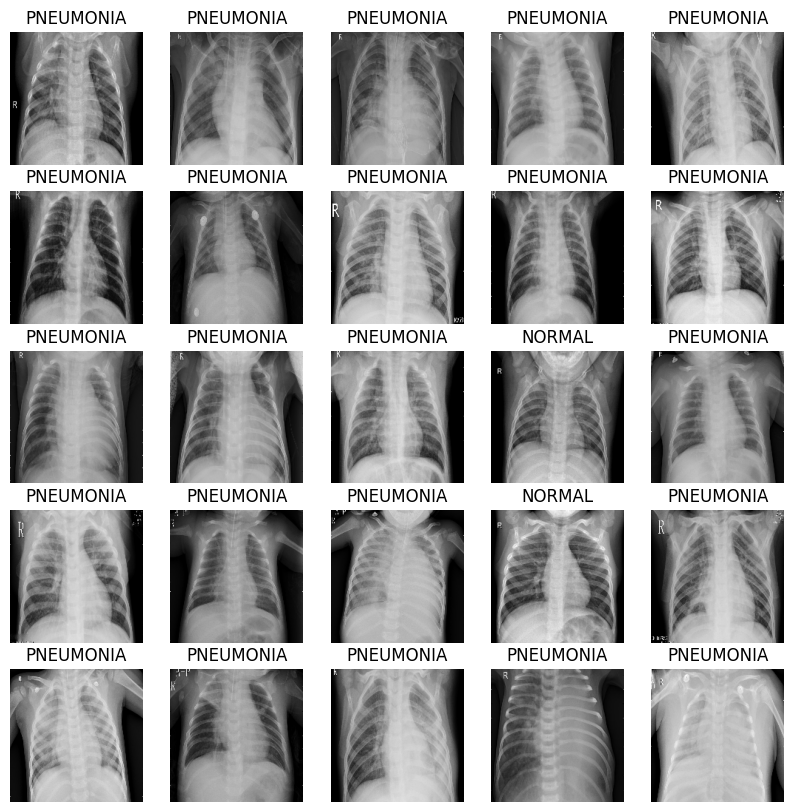

In [13]:
show_batch(image_batch.numpy(), label_batch.numpy())


In [14]:
import os 
os.environ['KERAS_BACKEND'] = 'tensorflow'

import keras
from keras import layers

def conv_block(filters, inputs):
    x = layers.SeparableConv2D(filters, 3, activation="relu", padding="same")(inputs)
    x = layers.SeparableConv2D(filters, 3, activation="relu", padding="same")(x)
    x = layers.BatchNormalization()(x)
    outputs = layers.MaxPool2D()(x)

    return outputs


def dense_block(units, dropout_rate, inputs):
    x = layers.Dense(units, activation="relu")(inputs)
    x = layers.BatchNormalization()(x)
    outputs = layers.Dropout(dropout_rate)(x)

    return outputs


In [15]:
def build_model():
    inputs = keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(16, 3, activation="relu", padding="same")(x)
    x = layers.Conv2D(16, 3, activation="relu", padding="same")(x)
    x = layers.MaxPool2D()(x)

    x = conv_block(32, x)
    x = conv_block(64, x)

    x = conv_block(128, x)
    x = layers.Dropout(0.2)(x)

    x = conv_block(256, x)
    x = layers.Dropout(0.2)(x)

    x = layers.Flatten()(x)
    x = dense_block(512, 0.7, x)
    x = dense_block(128, 0.5, x)
    x = dense_block(64, 0.3, x)

    outputs = layers.Dense(1, activation="sigmoid")(x)

    model = keras.Model(inputs=inputs, outputs=outputs)
    return model


In [16]:
initial_bias = np.log([COUNT_PNEUMONIA / COUNT_NORMAL])
print("Initial bias: {:.5f}".format(initial_bias[0]))

TRAIN_IMG_COUNT = COUNT_NORMAL + COUNT_PNEUMONIA
weight_for_0 = (1 / COUNT_NORMAL) * (TRAIN_IMG_COUNT) / 2.0
weight_for_1 = (1 / COUNT_PNEUMONIA) * (TRAIN_IMG_COUNT) / 2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print("Weight for class 0: {:.2f}".format(weight_for_0))
print("Weight for class 1: {:.2f}".format(weight_for_1))


Initial bias: 1.05724
Weight for class 0: 1.94
Weight for class 1: 0.67


In [17]:
checkpoint_cb = keras.callbacks.ModelCheckpoint("xray_model.keras", save_best_only=True)

early_stopping_cb = keras.callbacks.EarlyStopping(
    patience=10, restore_best_weights=True
)

In [18]:
initial_learning_rate = 0.015
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)


In [19]:
with strategy.scope():
    model = build_model()

    METRICS = [
        keras.metrics.BinaryAccuracy(),
        keras.metrics.Precision(name="precision"),
        keras.metrics.Recall(name="recall"),
    ]
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
        loss="binary_crossentropy",
        metrics=METRICS,
    )

history = model.fit(
    train_ds,
    epochs=100,
    validation_data=val_ds,
    class_weight=class_weight,
    callbacks=[checkpoint_cb, early_stopping_cb],
)


Epoch 1/100


2024-06-18 10:26:21.287558: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:9: Filling up shuffle buffer (this may take a while): 236 of 10000
2024-06-18 10:26:40.668930: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:9: Filling up shuffle buffer (this may take a while): 889 of 10000
2024-06-18 10:26:52.118948: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:9: Filling up shuffle buffer (this may take a while): 1202 of 10000
2024-06-18 10:27:03.453872: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:9: Filling up shuffle buffer (this may take a while): 2561 of 10000
2024-06-18 10:27:13.165493: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


    168/Unknown 122s 332ms/step - binary_accuracy: 0.6804 - loss: 0.6254 - precision: 0.8707 - recall: 0.6640

2024-06-18 10:28:09.042588: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
2024-06-18 10:28:22.357623: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:9: Filling up shuffle buffer (this may take a while): 236 of 10000
2024-06-18 10:28:40.425079: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:9: Filling up shuffle buffer (this may take a while): 776 of 10000
2024-06-18 10:28:50.559413: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:9: Filling up shuffle buffer (this may take a while): 1092

168/168 ━━━━━━━━━━━━━━━━━━━━ 189s 735ms/step - binary_accuracy: 0.6810 - loss: 0.6244 - precision: 0.8710 - recall: 0.6645 - val_binary_accuracy: 0.7345 - val_loss: 1.8409 - val_precision: 0.7374 - val_recall: 0.9948
Epoch 2/100


2024-06-18 10:29:16.245519: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step - binary_accuracy: 0.8840 - loss: 0.2946 - precision: 0.9593 - recall: 0.8809

2024-06-18 10:30:00.453544: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


168/168 ━━━━━━━━━━━━━━━━━━━━ 46s 275ms/step - binary_accuracy: 0.8841 - loss: 0.2944 - precision: 0.9594 - recall: 0.8809 - val_binary_accuracy: 0.9486 - val_loss: 0.1606 - val_precision: 0.9784 - val_recall: 0.9514
Epoch 3/100


2024-06-18 10:30:02.655408: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step - binary_accuracy: 0.9059 - loss: 0.2295 - precision: 0.9685 - recall: 0.9023

2024-06-18 10:30:46.060767: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


168/168 ━━━━━━━━━━━━━━━━━━━━ 46s 272ms/step - binary_accuracy: 0.9060 - loss: 0.2294 - precision: 0.9686 - recall: 0.9024 - val_binary_accuracy: 0.7384 - val_loss: 1.5529 - val_precision: 0.7384 - val_recall: 1.0000
Epoch 4/100


2024-06-18 10:30:48.516230: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step - binary_accuracy: 0.9209 - loss: 0.1890 - precision: 0.9713 - recall: 0.9206

2024-06-18 10:31:33.647208: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


168/168 ━━━━━━━━━━━━━━━━━━━━ 48s 285ms/step - binary_accuracy: 0.9209 - loss: 0.1889 - precision: 0.9713 - recall: 0.9206 - val_binary_accuracy: 0.9109 - val_loss: 0.2373 - val_precision: 0.9970 - val_recall: 0.8819
Epoch 5/100


2024-06-18 10:31:36.441428: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step - binary_accuracy: 0.9364 - loss: 0.1645 - precision: 0.9796 - recall: 0.9336

2024-06-18 10:32:17.581892: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


168/168 ━━━━━━━━━━━━━━━━━━━━ 43s 259ms/step - binary_accuracy: 0.9364 - loss: 0.1645 - precision: 0.9796 - recall: 0.9335 - val_binary_accuracy: 0.7946 - val_loss: 0.6620 - val_precision: 0.9982 - val_recall: 0.7231
Epoch 6/100


2024-06-18 10:32:19.895136: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step - binary_accuracy: 0.9369 - loss: 0.1633 - precision: 0.9816 - recall: 0.9322

2024-06-18 10:33:03.134546: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


168/168 ━━━━━━━━━━━━━━━━━━━━ 46s 270ms/step - binary_accuracy: 0.9369 - loss: 0.1632 - precision: 0.9816 - recall: 0.9323 - val_binary_accuracy: 0.9370 - val_loss: 0.2533 - val_precision: 0.9929 - val_recall: 0.9213
Epoch 7/100


2024-06-18 10:33:05.423612: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step - binary_accuracy: 0.9526 - loss: 0.1286 - precision: 0.9884 - recall: 0.9472

2024-06-18 10:33:58.223616: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


168/168 ━━━━━━━━━━━━━━━━━━━━ 56s 333ms/step - binary_accuracy: 0.9526 - loss: 0.1286 - precision: 0.9884 - recall: 0.9472 - val_binary_accuracy: 0.7810 - val_loss: 1.6695 - val_precision: 0.7729 - val_recall: 0.9961
Epoch 8/100


2024-06-18 10:34:01.316364: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step - binary_accuracy: 0.9404 - loss: 0.1464 - precision: 0.9815 - recall: 0.9371

2024-06-18 10:34:54.669461: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


168/168 ━━━━━━━━━━━━━━━━━━━━ 56s 335ms/step - binary_accuracy: 0.9404 - loss: 0.1464 - precision: 0.9815 - recall: 0.9371 - val_binary_accuracy: 0.9496 - val_loss: 0.1363 - val_precision: 0.9958 - val_recall: 0.9357
Epoch 9/100


2024-06-18 10:34:57.494192: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step - binary_accuracy: 0.9481 - loss: 0.1265 - precision: 0.9824 - recall: 0.9469

2024-06-18 10:35:45.858436: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


168/168 ━━━━━━━━━━━━━━━━━━━━ 51s 306ms/step - binary_accuracy: 0.9481 - loss: 0.1266 - precision: 0.9825 - recall: 0.9469 - val_binary_accuracy: 0.9312 - val_loss: 0.1983 - val_precision: 0.9929 - val_recall: 0.9134
Epoch 10/100


2024-06-18 10:35:49.060444: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step - binary_accuracy: 0.9531 - loss: 0.1233 - precision: 0.9889 - recall: 0.9474

2024-06-18 10:36:43.931380: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


168/168 ━━━━━━━━━━━━━━━━━━━━ 58s 344ms/step - binary_accuracy: 0.9532 - loss: 0.1233 - precision: 0.9889 - recall: 0.9474 - val_binary_accuracy: 0.9419 - val_loss: 0.2382 - val_precision: 0.9355 - val_recall: 0.9895
Epoch 11/100


2024-06-18 10:36:46.945221: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step - binary_accuracy: 0.9509 - loss: 0.1373 - precision: 0.9861 - recall: 0.9471

2024-06-18 10:37:39.501333: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


168/168 ━━━━━━━━━━━━━━━━━━━━ 55s 326ms/step - binary_accuracy: 0.9509 - loss: 0.1373 - precision: 0.9861 - recall: 0.9471 - val_binary_accuracy: 0.8440 - val_loss: 0.6291 - val_precision: 0.8313 - val_recall: 0.9895
Epoch 12/100


2024-06-18 10:37:41.684115: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step - binary_accuracy: 0.8787 - loss: 0.3145 - precision: 0.9596 - recall: 0.8729

2024-06-18 10:38:25.490760: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


168/168 ━━━━━━━━━━━━━━━━━━━━ 46s 274ms/step - binary_accuracy: 0.8788 - loss: 0.3141 - precision: 0.9597 - recall: 0.8730 - val_binary_accuracy: 0.8081 - val_loss: 0.4261 - val_precision: 0.9965 - val_recall: 0.7428
Epoch 13/100


2024-06-18 10:38:27.781820: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step - binary_accuracy: 0.9336 - loss: 0.1774 - precision: 0.9817 - recall: 0.9276

2024-06-18 10:39:15.095508: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


168/168 ━━━━━━━━━━━━━━━━━━━━ 50s 297ms/step - binary_accuracy: 0.9336 - loss: 0.1773 - precision: 0.9817 - recall: 0.9277 - val_binary_accuracy: 0.9244 - val_loss: 0.1732 - val_precision: 0.9985 - val_recall: 0.8990
Epoch 14/100


2024-06-18 10:39:17.636433: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step - binary_accuracy: 0.9491 - loss: 0.1448 - precision: 0.9846 - recall: 0.9462

2024-06-18 10:40:01.522615: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


168/168 ━━━━━━━━━━━━━━━━━━━━ 47s 277ms/step - binary_accuracy: 0.9491 - loss: 0.1447 - precision: 0.9846 - recall: 0.9462 - val_binary_accuracy: 0.9632 - val_loss: 0.0817 - val_precision: 0.9918 - val_recall: 0.9580
Epoch 15/100


2024-06-18 10:40:04.101551: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step - binary_accuracy: 0.9518 - loss: 0.1399 - precision: 0.9870 - recall: 0.9474

2024-06-18 10:40:50.872287: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


168/168 ━━━━━━━━━━━━━━━━━━━━ 49s 293ms/step - binary_accuracy: 0.9518 - loss: 0.1399 - precision: 0.9870 - recall: 0.9474 - val_binary_accuracy: 0.9738 - val_loss: 0.0528 - val_precision: 0.9855 - val_recall: 0.9790
Epoch 16/100


2024-06-18 10:40:53.416383: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step - binary_accuracy: 0.9626 - loss: 0.1072 - precision: 0.9900 - recall: 0.9592

2024-06-18 10:41:39.046137: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


168/168 ━━━━━━━━━━━━━━━━━━━━ 48s 285ms/step - binary_accuracy: 0.9626 - loss: 0.1073 - precision: 0.9900 - recall: 0.9592 - val_binary_accuracy: 0.9448 - val_loss: 0.1302 - val_precision: 0.9986 - val_recall: 0.9265
Epoch 17/100


2024-06-18 10:41:41.414662: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step - binary_accuracy: 0.9626 - loss: 0.1071 - precision: 0.9906 - recall: 0.9587

2024-06-18 10:42:26.850707: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


168/168 ━━━━━━━━━━━━━━━━━━━━ 48s 287ms/step - binary_accuracy: 0.9626 - loss: 0.1072 - precision: 0.9906 - recall: 0.9586 - val_binary_accuracy: 0.9797 - val_loss: 0.0496 - val_precision: 0.9907 - val_recall: 0.9816
Epoch 18/100


2024-06-18 10:42:29.581441: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step - binary_accuracy: 0.9674 - loss: 0.0968 - precision: 0.9924 - recall: 0.9633

2024-06-18 10:43:16.804219: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


168/168 ━━━━━━━━━━━━━━━━━━━━ 49s 293ms/step - binary_accuracy: 0.9673 - loss: 0.0969 - precision: 0.9924 - recall: 0.9633 - val_binary_accuracy: 0.9797 - val_loss: 0.1024 - val_precision: 0.9907 - val_recall: 0.9816
Epoch 19/100


2024-06-18 10:43:19.000158: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step - binary_accuracy: 0.9671 - loss: 0.0812 - precision: 0.9913 - recall: 0.9641

2024-06-18 10:44:03.926165: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


168/168 ━━━━━━━━━━━━━━━━━━━━ 48s 283ms/step - binary_accuracy: 0.9670 - loss: 0.0812 - precision: 0.9913 - recall: 0.9640 - val_binary_accuracy: 0.9632 - val_loss: 0.0812 - val_precision: 0.9986 - val_recall: 0.9514
Epoch 20/100


2024-06-18 10:44:06.747954: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step - binary_accuracy: 0.9792 - loss: 0.0680 - precision: 0.9953 - recall: 0.9766

2024-06-18 10:44:52.354174: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


168/168 ━━━━━━━━━━━━━━━━━━━━ 48s 287ms/step - binary_accuracy: 0.9791 - loss: 0.0681 - precision: 0.9952 - recall: 0.9765 - val_binary_accuracy: 0.9748 - val_loss: 0.0780 - val_precision: 0.9946 - val_recall: 0.9711
Epoch 21/100


2024-06-18 10:44:55.127413: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step - binary_accuracy: 0.9655 - loss: 0.1027 - precision: 0.9873 - recall: 0.9658

2024-06-18 10:45:40.608325: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


168/168 ━━━━━━━━━━━━━━━━━━━━ 48s 283ms/step - binary_accuracy: 0.9654 - loss: 0.1028 - precision: 0.9873 - recall: 0.9657 - val_binary_accuracy: 0.8188 - val_loss: 5.6994 - val_precision: 0.8227 - val_recall: 0.9619
Epoch 22/100


2024-06-18 10:45:42.817254: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step - binary_accuracy: 0.9526 - loss: 0.1258 - precision: 0.9853 - recall: 0.9502

2024-06-18 10:46:29.688047: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


168/168 ━━━━━━━━━━━━━━━━━━━━ 49s 293ms/step - binary_accuracy: 0.9526 - loss: 0.1258 - precision: 0.9853 - recall: 0.9502 - val_binary_accuracy: 0.9641 - val_loss: 0.1140 - val_precision: 0.9571 - val_recall: 0.9961
Epoch 23/100


2024-06-18 10:46:32.010916: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step - binary_accuracy: 0.9575 - loss: 0.1153 - precision: 0.9890 - recall: 0.9531

2024-06-18 10:47:17.266681: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


168/168 ━━━━━━━━━━━━━━━━━━━━ 48s 284ms/step - binary_accuracy: 0.9575 - loss: 0.1153 - precision: 0.9890 - recall: 0.9531 - val_binary_accuracy: 0.9816 - val_loss: 0.0469 - val_precision: 0.9934 - val_recall: 0.9816
Epoch 24/100


2024-06-18 10:47:19.622952: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step - binary_accuracy: 0.9640 - loss: 0.1006 - precision: 0.9899 - recall: 0.9612

2024-06-18 10:48:02.395241: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


168/168 ━━━━━━━━━━━━━━━━━━━━ 45s 269ms/step - binary_accuracy: 0.9640 - loss: 0.1007 - precision: 0.9899 - recall: 0.9612 - val_binary_accuracy: 0.7403 - val_loss: 4.7541 - val_precision: 0.7398 - val_recall: 1.0000
Epoch 25/100


2024-06-18 10:48:05.043597: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step - binary_accuracy: 0.9432 - loss: 0.1647 - precision: 0.9807 - recall: 0.9417

2024-06-18 10:48:49.898784: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


168/168 ━━━━━━━━━━━━━━━━━━━━ 47s 280ms/step - binary_accuracy: 0.9432 - loss: 0.1645 - precision: 0.9807 - recall: 0.9418 - val_binary_accuracy: 0.8876 - val_loss: 0.3455 - val_precision: 0.8696 - val_recall: 0.9974
Epoch 26/100


2024-06-18 10:48:52.193490: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step - binary_accuracy: 0.9585 - loss: 0.1034 - precision: 0.9902 - recall: 0.9534

2024-06-18 10:49:40.722772: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


168/168 ━━━━━━━━━━━━━━━━━━━━ 51s 304ms/step - binary_accuracy: 0.9585 - loss: 0.1034 - precision: 0.9902 - recall: 0.9534 - val_binary_accuracy: 0.7597 - val_loss: 1.2961 - val_precision: 0.7644 - val_recall: 0.9751
Epoch 27/100


2024-06-18 10:49:43.234297: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step - binary_accuracy: 0.9674 - loss: 0.0999 - precision: 0.9922 - recall: 0.9637

2024-06-18 10:50:32.979695: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


168/168 ━━━━━━━━━━━━━━━━━━━━ 53s 312ms/step - binary_accuracy: 0.9674 - loss: 0.1000 - precision: 0.9922 - recall: 0.9636 - val_binary_accuracy: 0.9322 - val_loss: 0.1668 - val_precision: 0.9957 - val_recall: 0.9121
Epoch 28/100


2024-06-18 10:50:35.747116: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step - binary_accuracy: 0.9330 - loss: 0.1694 - precision: 0.9779 - recall: 0.9305

2024-06-18 10:51:25.118410: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


168/168 ━━━━━━━━━━━━━━━━━━━━ 52s 311ms/step - binary_accuracy: 0.9330 - loss: 0.1696 - precision: 0.9779 - recall: 0.9304 - val_binary_accuracy: 0.8750 - val_loss: 0.3945 - val_precision: 0.8634 - val_recall: 0.9869
Epoch 29/100


2024-06-18 10:51:27.985493: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step - binary_accuracy: 0.9337 - loss: 0.2012 - precision: 0.9780 - recall: 0.9314

2024-06-18 10:52:14.911004: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


168/168 ━━━━━━━━━━━━━━━━━━━━ 50s 294ms/step - binary_accuracy: 0.9336 - loss: 0.2013 - precision: 0.9780 - recall: 0.9314 - val_binary_accuracy: 0.7859 - val_loss: 0.5367 - val_precision: 1.0000 - val_recall: 0.7100
Epoch 30/100


2024-06-18 10:52:17.501956: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step - binary_accuracy: 0.9392 - loss: 0.1590 - precision: 0.9817 - recall: 0.9353

2024-06-18 10:53:05.401019: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


168/168 ━━━━━━━━━━━━━━━━━━━━ 51s 303ms/step - binary_accuracy: 0.9392 - loss: 0.1590 - precision: 0.9817 - recall: 0.9353 - val_binary_accuracy: 0.9671 - val_loss: 0.0741 - val_precision: 0.9879 - val_recall: 0.9672
Epoch 31/100


2024-06-18 10:53:08.438607: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step - binary_accuracy: 0.9588 - loss: 0.1210 - precision: 0.9885 - recall: 0.9555

2024-06-18 10:54:01.114516: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


168/168 ━━━━━━━━━━━━━━━━━━━━ 56s 331ms/step - binary_accuracy: 0.9587 - loss: 0.1211 - precision: 0.9885 - recall: 0.9555 - val_binary_accuracy: 0.9641 - val_loss: 0.0867 - val_precision: 0.9919 - val_recall: 0.9593
Epoch 32/100


2024-06-18 10:54:04.037777: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step - binary_accuracy: 0.9581 - loss: 0.1203 - precision: 0.9869 - recall: 0.9561

2024-06-18 10:54:54.806613: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


168/168 ━━━━━━━━━━━━━━━━━━━━ 54s 318ms/step - binary_accuracy: 0.9581 - loss: 0.1203 - precision: 0.9869 - recall: 0.9561 - val_binary_accuracy: 0.9428 - val_loss: 0.1649 - val_precision: 0.9345 - val_recall: 0.9921
Epoch 33/100


2024-06-18 10:54:57.543961: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step - binary_accuracy: 0.9571 - loss: 0.1315 - precision: 0.9841 - recall: 0.9576

2024-06-18 10:55:42.325699: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


168/168 ━━━━━━━━━━━━━━━━━━━━ 48s 286ms/step - binary_accuracy: 0.9571 - loss: 0.1314 - precision: 0.9841 - recall: 0.9576 - val_binary_accuracy: 0.9806 - val_loss: 0.0523 - val_precision: 0.9907 - val_recall: 0.9829


2024-06-18 10:55:45.586813: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


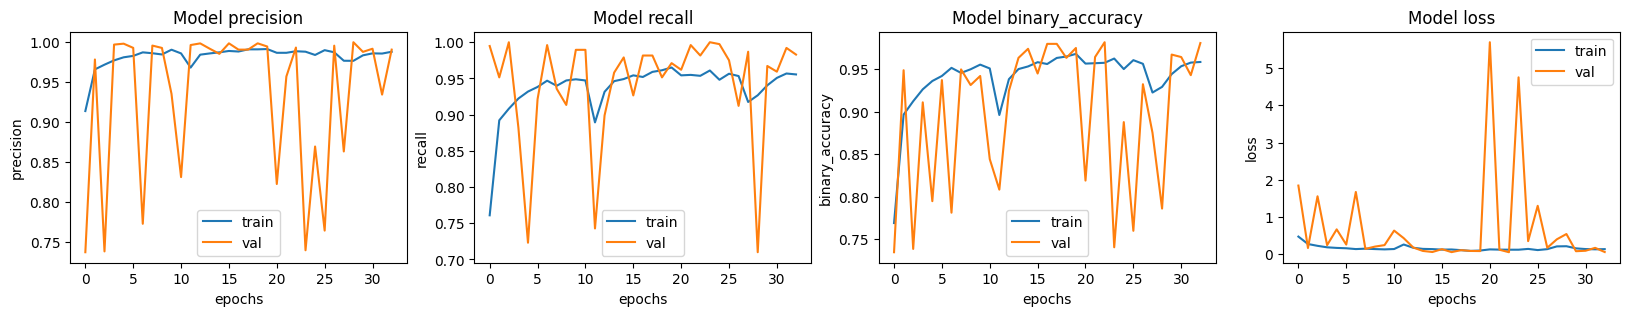

In [20]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(["precision", "recall", "binary_accuracy", "loss"]):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history["val_" + met])
    ax[i].set_title("Model {}".format(met))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(met)
    ax[i].legend(["train", "val"])


In [21]:
model.evaluate(test_ds, return_dict=True)


25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 119ms/step - binary_accuracy: 0.6691 - loss: 1.2673 - precision: 0.3855 - recall: 0.6485


2024-06-18 11:02:20.395360: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


{'binary_accuracy': 0.8108974099159241,
 'loss': 0.7473751306533813,
 'precision': 0.7730923891067505,
 'recall': 0.9871794581413269}

2024-06-18 11:03:19.311082: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
This image is %.2f percent %s (array([73.23647], dtype=float32), 'NORMAL')
This image is %.2f percent %s (array([26.763529], dtype=float32), 'PNEUMONIA')


2024-06-18 11:03:22.627480: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


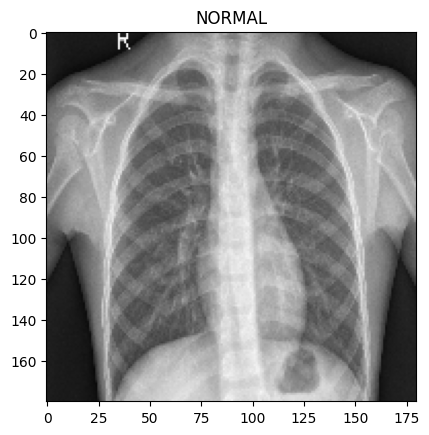

In [23]:
for image, label in test_ds.take(1):
    plt.imshow(image[0] / 255.0)
    plt.title(CLASS_NAMES[label[0].numpy()])

prediction = model.predict(test_ds.take(1))[0]
scores = [1 - prediction, prediction]

for score, name in zip(scores, CLASS_NAMES):
    print("This image is %.2f percent %s", ((100 * score), name))
